<a href="https://colab.research.google.com/github/jlibleft/AI_training/blob/main/ostateczny_notatnik_TOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pynrrd
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.8 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

'''
# Funkcja do segmentacji aorty na podstawie progowania
def threshold_segmentation(image_array, lower_threshold, upper_threshold):
    # Ustaw piksele spoza zakresu na 0, a piksele w zakresie na 1
    segmented_image=np.zeros(image_array.shape)
    segmented_image = np.where((image_array >= lower_threshold) & (image_array <= upper_threshold), 1, 0)
    return segmented_image
'''

def data_load(filepath):
  # Ścieżka do pliku nrrd
  nrrd_file_path = filepath

  # Wczytaj plik nrrd
  image = sitk.ReadImage(nrrd_file_path)

  # Konwertuj obraz do numpy array
  image_array = sitk.GetArrayFromImage(image)

  # Wymiary obrazu
  depth, height, width = image_array.shape
  slice_index_list = []
  pixel_range_list = []
  for slice_index in range(depth):
        slice_2d = image_array[slice_index, :, :]
        min_pixel_value = slice_2d.min()
        max_pixel_value = slice_2d.max()
        pixel_range = (slice_2d.min(), slice_2d.max())
        slice_index_list.append(slice_index)
        pixel_range_list.append(pixel_range)
  df = pd.DataFrame({'Przekrój': slice_index_list, 'Zakres wartości pikseli': pixel_range_list})


  return slice_2d, image_array


ZAPISYWANIE PNG NA DRIVE, ZROBIC TYLKO RAZ!!!!

In [ ]:
import nrrd
from PIL import Image
import numpy as np
import cv2
def manipulating_nrrd_contrast(img, level):
    img_c = img.astype(int).copy()
    factor = (80 * (level+255)) / (255 * (259-level)) #This 8 here is the value that i changes manually by try and test and found out that this works best
    img_c = factor * (img_c - 128) + 128
    img_c = np.clip(img_c, 0, 255)
    return img_c.astype(np.uint8)

for j in range(1,19):
  filename = f"/content/drive/MyDrive/Dongyang/D{j}/D{j}.nrrd"
  readdata, header = nrrd.read(filename)
  for i in range(readdata.shape[2]):
    b = np.asarray(readdata[:,:,i]).astype(int)
    final = Image.fromarray(manipulating_nrrd_contrast(b, 128))
    final.save(f'/content/drive/MyDrive/input_dir/D{j}-{i}.png')
    src = cv2.imread(f'/content/drive/MyDrive/input_dir/D{j}-{i}.png')
    final = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)
    final = np.flip(final, axis=1)
    cv2.imwrite(f'/content/drive/MyDrive/input_dir/D{j}-{i}.png', final)


In [ ]:
for i in range(1,19):
  nrrd_file_path = f"/content/drive/MyDrive/Dongyang/D{i}/D{i}.seg.nrrd"
  slice_2d, image_array =data_load(nrrd_file_path)
  depth, height, width = np.shape(image_array)
  for j in range(depth):
    plt.axis('off')
    plt.imsave(f'/content/drive/MyDrive/target_dir/D{i}-{j}.seg.png', image_array[j], cmap='gray')

In [ ]:
import os
input_dir = "/content/drive/MyDrive/input_dir"
target_dir = "/content/drive/MyDrive/target_dir"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 2840
/content/drive/MyDrive/input_dir/D1-0.png | /content/drive/MyDrive/target_dir/D1-0.seg.png
/content/drive/MyDrive/input_dir/D1-1.png | /content/drive/MyDrive/target_dir/D1-1.seg.png
/content/drive/MyDrive/input_dir/D1-10.png | /content/drive/MyDrive/target_dir/D1-10.seg.png
/content/drive/MyDrive/input_dir/D1-100.png | /content/drive/MyDrive/target_dir/D1-100.seg.png
/content/drive/MyDrive/input_dir/D1-101.png | /content/drive/MyDrive/target_dir/D1-101.seg.png
/content/drive/MyDrive/input_dir/D1-102.png | /content/drive/MyDrive/target_dir/D1-102.seg.png
/content/drive/MyDrive/input_dir/D1-103.png | /content/drive/MyDrive/target_dir/D1-103.seg.png
/content/drive/MyDrive/input_dir/D1-104.png | /content/drive/MyDrive/target_dir/D1-104.seg.png
/content/drive/MyDrive/input_dir/D1-105.png | /content/drive/MyDrive/target_dir/D1-105.seg.png
/content/drive/MyDrive/input_dir/D1-106.png | /content/drive/MyDrive/target_dir/D1-106.seg.png


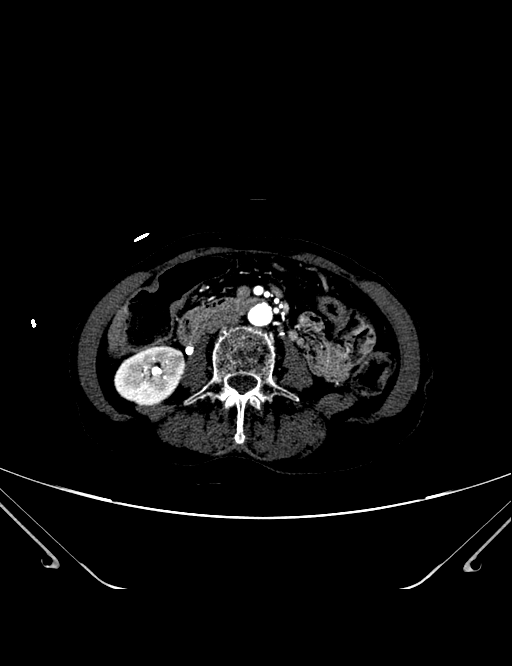

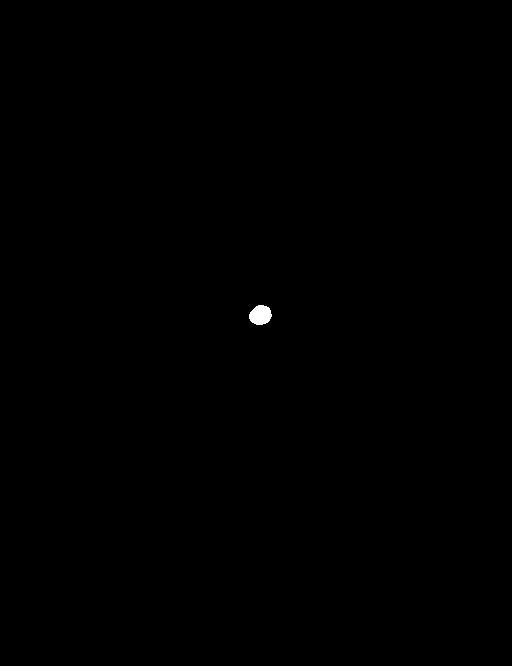

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps


display(Image(filename=input_img_paths[9]))
display(Image(filename=target_img_paths[9]))

In [ ]:

img_size = (160, 160)
num_classes = 3
batch_size = 32

import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size)
        target_img = tf_image.convert_image_dtype(target_img, "uint8")
        target_img = target_img / tensorflow.constant(255, dtype="uint8")

        return input_img, target_img

    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
from keras import layers


def get_model(img_size, num_classes):

    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs, )

    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

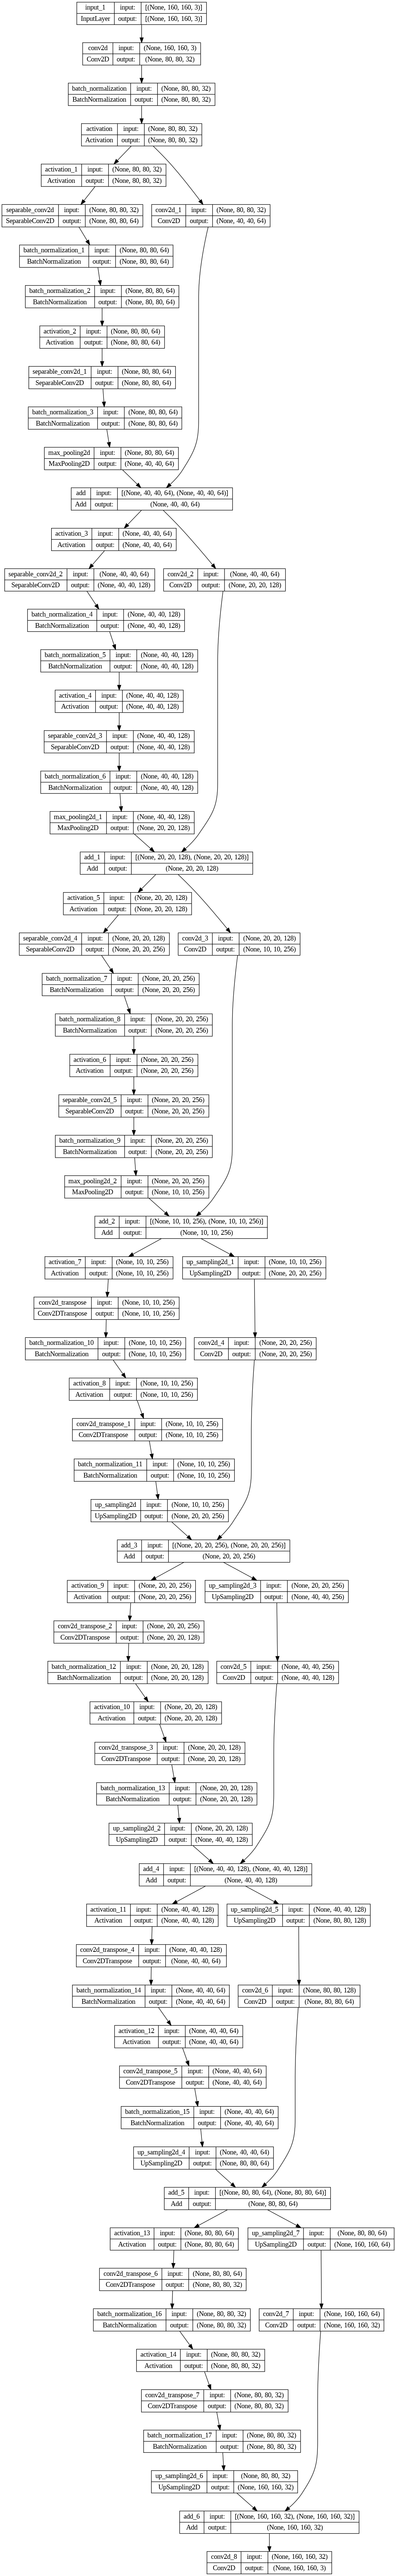

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/checksved.keras", save_best_only=True)
]
# Train the model, doing validation at the end of each epoch.
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)



Epoch 1/50
32/32 - 544s - loss: 0.2110 - val_loss: 0.3619 - 544s/epoch - 17s/step
Epoch 2/50
32/32 - 434s - loss: 0.0286 - val_loss: 0.0942 - 434s/epoch - 14s/step
Epoch 3/50
32/32 - 437s - loss: 0.0209 - val_loss: 0.0632 - 437s/epoch - 14s/step
Epoch 4/50
32/32 - 437s - loss: 0.0171 - val_loss: 0.0575 - 437s/epoch - 14s/step
Epoch 5/50
32/32 - 435s - loss: 0.0146 - val_loss: 0.0570 - 435s/epoch - 14s/step
Epoch 6/50
32/32 - 437s - loss: 0.0128 - val_loss: 0.0580 - 437s/epoch - 14s/step
Epoch 7/50
32/32 - 440s - loss: 0.0115 - val_loss: 0.0592 - 440s/epoch - 14s/step
Epoch 8/50
32/32 - 445s - loss: 0.0104 - val_loss: 0.0602 - 445s/epoch - 14s/step
Epoch 9/50
32/32 - 438s - loss: 0.0095 - val_loss: 0.0610 - 438s/epoch - 14s/step
Epoch 10/50
32/32 - 438s - loss: 0.0088 - val_loss: 0.0615 - 438s/epoch - 14s/step
Epoch 11/50
32/32 - 448s - loss: 0.0082 - val_loss: 0.0616 - 448s/epoch - 14s/step
Epoch 12/50
32/32 - 447s - loss: 0.0076 - val_loss: 0.0611 - 447s/epoch - 14s/step
Epoch 13/50
3

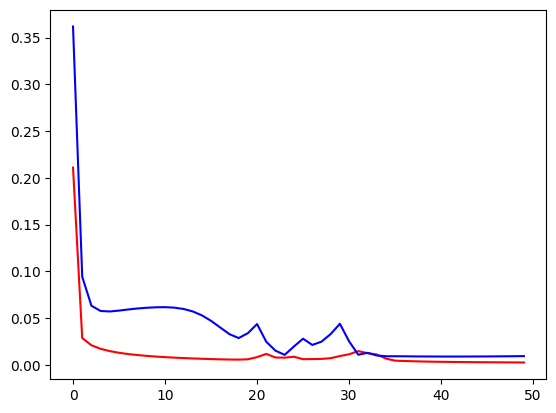

In [ ]:
plt.plot(history.history['loss'], c = 'r' )
plt.plot(history.history['val_loss'], c = 'b' )

32/32 [==============================] - 106s 3s/step


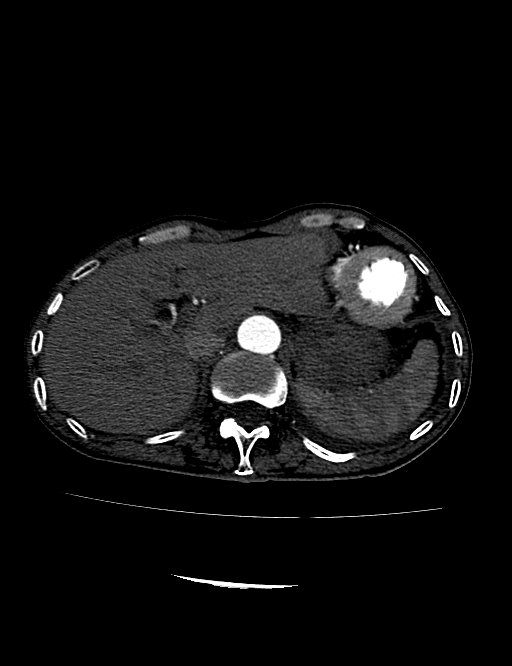

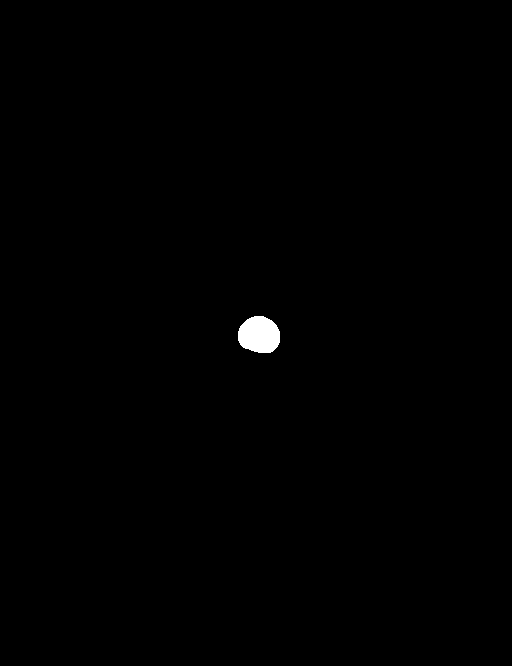

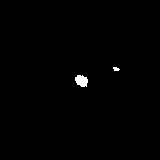

In [ ]:
# Generate predictions for all images in the validation set
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


In [ ]:
def save_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    img = img.save(f'/content/drive/MyDrive/predicted_img/pred{i}.png')
    img = Image.open(f'/content/drive/MyDrive/predicted_img/pred{i}.png')
    img = img.resize((512, 666))
    img = img.save(f'/content/drive/MyDrive/predicted_img/pred{i}.png')

for i in range(len(val_preds)):
  save_mask(i)

In [ ]:
for i in range(len(val_preds)):
  src = cv2.imread(val_target_img_paths[i])
  cv2.imwrite(f'/content/drive/MyDrive/target/target{i}.png', src)

In [ ]:
for i in range(len(val_preds)):
  src = cv2.imread(val_input_img_paths[i])
  cv2.imwrite(f'/content/drive/MyDrive/input/input{i}.png', src)

In [ ]:
predicted_dir = "/content/drive/MyDrive/predicted_img"

pred_img_paths = sorted(
    [
        os.path.join(predicted_dir, fname)
        for fname in os.listdir(predicted_dir)
        if fname.endswith(".png")
    ]
)

input_dir = "/content/drive/MyDrive/input"

val_input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)

target_dir = "/content/drive/MyDrive/target"

val_target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

In [ ]:
example_pred = Image.open(pred_img_paths[10])
example_input = Image.open(val_input_img_paths[10])
example_target = Image.open(val_target_img_paths[10])

NameError: name 'val_input_img_paths' is not defined

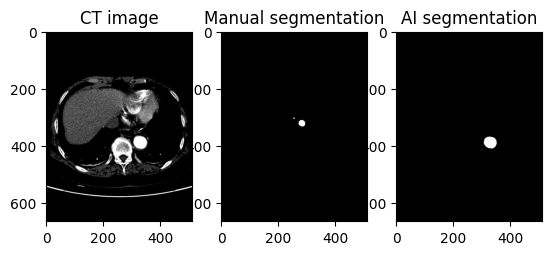

In [ ]:
#dif1 = np.logical_xor(example_input,example_target)
#dif2 = np.logical_xor(example_input,example_pred)

plt.subplot(1, 3, 1)
plt.title('CT image')
plt.imshow(example_input, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Manual segmentation')
plt.imshow(example_target, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("AI segmentation")
plt.imshow(example_pred, cmap='gray')
plt.show()